In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_curve, roc_auc_score, accuracy_score, 
                           precision_score, recall_score, f1_score)

# SMOTE for handling imbalanced data
from imblearn.over_sampling import SMOTE

# Set style for better plots
plt.style.use('seaborn-v0_8')


In [10]:
df = pd.read_csv('creditcard.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nClass Distribution:")
print(df['Class'].value_counts())
print(f"Fraud Percentage: {df['Class'].sum() / len(df) * 100:.2f}%")

print("\nMissing Values:")
print(df.isnull().sum().sum())

Dataset Shape: (284807, 31)

First few rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -

Text(0, 0.5, 'Amount')

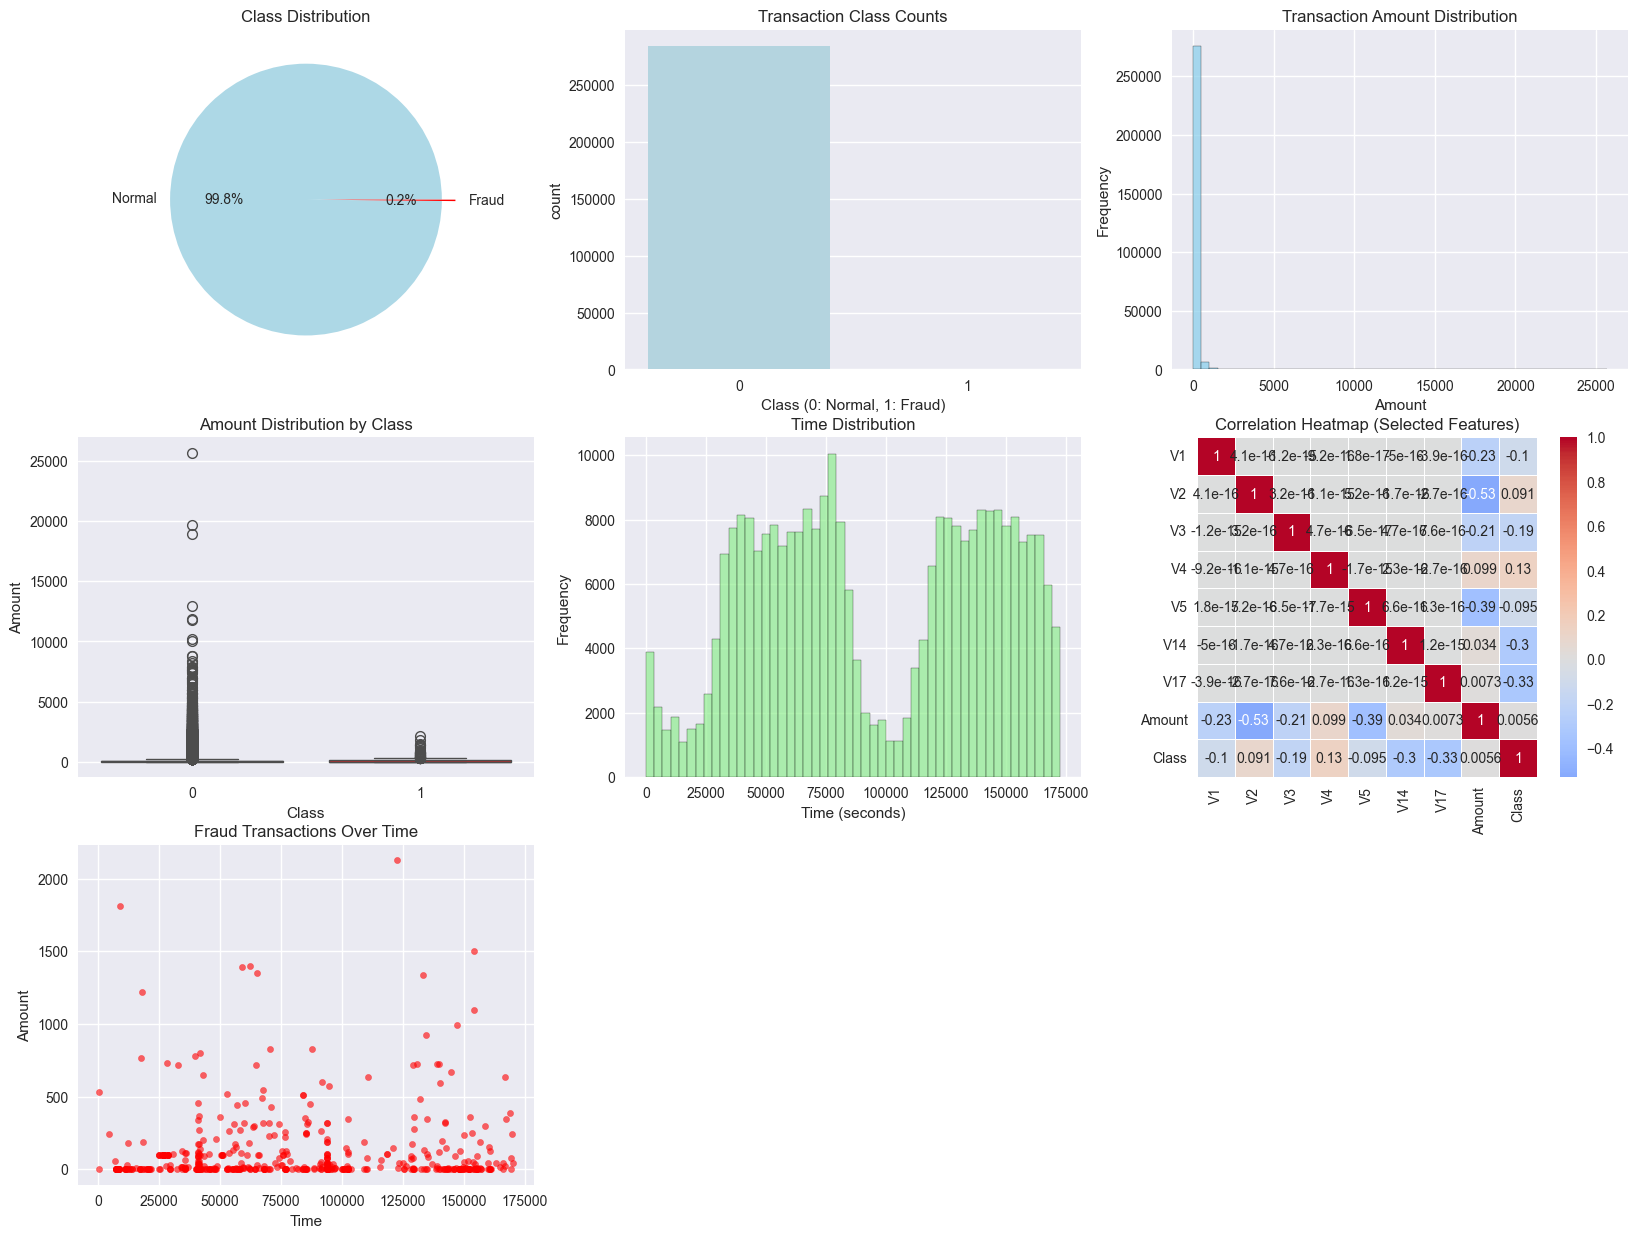

In [11]:
# Exploratory Data Analysis (EDA)
fig = plt.figure(figsize=(20, 15))

# 1. Class Distribution
plt.subplot(3, 3, 1)
class_counts = df['Class'].value_counts()
plt.pie(class_counts.values, labels=['Normal', 'Fraud'], autopct='%1.1f%%', 
        colors=['lightblue', 'red'], explode=(0, 0.1))
plt.title('Class Distribution')

# 2. Class Count Bar Plot
plt.subplot(3, 3, 2)
sns.countplot(data=df, x='Class', palette=['lightblue', 'red'])
plt.title('Transaction Class Counts')
plt.xlabel('Class (0: Normal, 1: Fraud)')

# 3. Amount Distribution
plt.subplot(3, 3, 3)
plt.hist(df['Amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')

# 4. Amount by Class (Box Plot)
plt.subplot(3, 3, 4)
sns.boxplot(data=df, x='Class', y='Amount', palette=['lightblue', 'red'])
plt.title('Amount Distribution by Class')

# 5. Time Distribution
plt.subplot(3, 3, 5)
plt.hist(df['Time'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Time Distribution')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

# 6. Correlation heatmap for selected features
plt.subplot(3, 3, 6)
# Select a subset of features for correlation analysis
features_subset = ['V1', 'V2', 'V3', 'V4', 'V5', 'V14', 'V17', 'Amount', 'Class']
correlation_matrix = df[features_subset].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Heatmap (Selected Features)')

# 7. Fraud transactions over time
plt.subplot(3, 3, 7)
fraud_data = df[df['Class'] == 1]
plt.scatter(fraud_data['Time'], fraud_data['Amount'], alpha=0.6, color='red', s=20)
plt.title('Fraud Transactions Over Time')
plt.xlabel('Time')
plt.ylabel('Amount')

Original dataset shape: (284807, 30)
Original class distribution: [284315    492]

Training set shape: (227845, 30)
Test set shape: (56962, 30)
Training set class distribution: [227451    394]

After SMOTE - Training set shape: (454902, 30)
After SMOTE - Class distribution: [227451 227451]


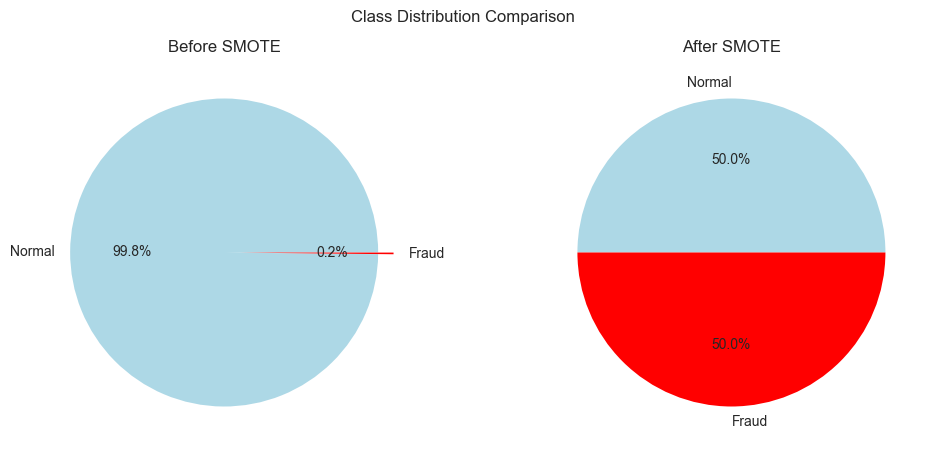

In [12]:
#Data Preprocessing and SMOTE
X = df.drop(['Class'], axis=1)
y = df['Class']

print("Original dataset shape:", X.shape)
print("Original class distribution:", np.bincount(y))

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE - Training set shape: {X_train_smote.shape}")
print(f"After SMOTE - Class distribution: {np.bincount(y_train_smote)}")

# Feature scaling
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Visualize class distribution before and after SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
ax1.pie(np.bincount(y_train), labels=['Normal', 'Fraud'], autopct='%1.1f%%', 
        colors=['lightblue', 'red'], explode=(0, 0.1))
ax1.set_title('Before SMOTE')

# After SMOTE
ax2.pie(np.bincount(y_train_smote), labels=['Normal', 'Fraud'], autopct='%1.1f%%', 
        colors=['lightblue', 'red'])
ax2.set_title('After SMOTE')

plt.suptitle('Class Distribution Comparison')
plt.show()

In [13]:
#Model Training and Implementation
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

model_results = {}
trained_models = {}

print("Training Models...")
print("=" * 50)

for name, model in models.items():
    print(f"Training {name}...")

  # Train the model
    model.fit(X_train_smote_scaled, y_train_smote)
    trained_models[name] = model

  # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

   # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    
    # Store results
    model_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")  
    

Training Models...
Training Logistic Regression...
Logistic Regression - Accuracy: 0.9899, AUC: 0.9765
Training Random Forest...
Random Forest - Accuracy: 0.9994, AUC: 0.9644
Training XGBoost...
XGBoost - Accuracy: 0.9994, AUC: 0.9854


In [14]:
# Create Hybrid Model (Voting Classifier)
print("\nTraining Hybrid Model (Random Forest + XGBoost)...")
hybrid_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(random_state=42, eval_metric='logloss'))
    ],
    voting='soft'
)
hybrid_model.fit(X_train_smote_scaled, y_train_smote)
trained_models['Hybrid (RF + XGB)'] = hybrid_model

# Hybrid model predictions
y_pred_hybrid = hybrid_model.predict(X_test_scaled)
y_pred_proba_hybrid = hybrid_model.predict_proba(X_test_scaled)[:, 1]


# Calculate hybrid model metrics
model_results['Hybrid (RF + XGB)'] = {
    'accuracy': accuracy_score(y_test, y_pred_hybrid),
    'precision': precision_score(y_test, y_pred_hybrid),
    'recall': recall_score(y_test, y_pred_hybrid),
    'f1_score': f1_score(y_test, y_pred_hybrid),
    'auc': roc_auc_score(y_test, y_pred_proba_hybrid),
    'predictions': y_pred_hybrid,
    'probabilities': y_pred_proba_hybrid
}
print(f"Hybrid Model - Accuracy: {model_results['Hybrid (RF + XGB)']['accuracy']:.4f}, "
      f"AUC: {model_results['Hybrid (RF + XGB)']['auc']:.4f}")


Training Hybrid Model (Random Forest + XGBoost)...
Hybrid Model - Accuracy: 0.9994, AUC: 0.9819


In [20]:
# Generate comprehensive performance report
def generate_detailed_report():
    print("=" * 80)
    print("COMPREHENSIVE CREDIT CARD FRAUD DETECTION REPORT")
    print("=" * 80)
    
    print(f"\nDataset Overview:")
    print(f"- Total Transactions: {len(df):,}")
    print(f"- Fraud Transactions: {df['Class'].sum():,}")
    print(f"- Normal Transactions: {len(df) - df['Class'].sum():,}")
    print(f"- Fraud Rate: {df['Class'].mean()*100:.3f}%")
    
    print(f"\nTest Set Performance:")
    print(f"- Test Set Size: {len(y_test):,} transactions")
    print(f"- Test Set Fraud Rate: {y_test.mean()*100:.3f}%")
    
    print("\n" + "="*80)
    print("INDIVIDUAL MODEL PERFORMANCE")
    print("="*80)
    
    for model_name, results in model_results.items():
        print(f"\n{model_name.upper()}")
        print("-" * len(model_name))
        print(f"Accuracy:  {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
        print(f"Precision: {results['precision']:.4f} ({results['precision']*100:.2f}%)")
        print(f"Recall:    {results['recall']:.4f} ({results['recall']*100:.2f}%)")
        print(f"F1-Score:  {results['f1_score']:.4f} ({results['f1_score']*100:.2f}%)")
        print(f"AUC:       {results['auc']:.4f} ({results['auc']*100:.2f}%)")
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, results['predictions'])
        print(f"\nConfusion Matrix:")
        print(f"  Predicted:    Normal  Fraud")
        print(f"  Normal:       {cm[0,0]:6d}  {cm[0,1]:5d}")
        print(f"  Fraud:        {cm[1,0]:6d}  {cm[1,1]:5d}")
        
        # Additional metrics
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        print(f"\nAdditional Metrics:")
        print(f"  True Positives:  {tp}")
        print(f"  False Positives: {fp}")
        print(f"  True Negatives:  {tn}")
        print(f"  False Negatives: {fn}")
        print(f"  Specificity:     {specificity:.4f}")
    
    print("\n" + "="*80)
generate_detailed_report()

COMPREHENSIVE CREDIT CARD FRAUD DETECTION REPORT

Dataset Overview:
- Total Transactions: 284,807
- Fraud Transactions: 492
- Normal Transactions: 284,315
- Fraud Rate: 0.173%

Test Set Performance:
- Test Set Size: 56,962 transactions
- Test Set Fraud Rate: 0.172%

INDIVIDUAL MODEL PERFORMANCE

LOGISTIC REGRESSION
-------------------
Accuracy:  0.9899 (98.99%)
Precision: 0.1341 (13.41%)
Recall:    0.8980 (89.80%)
F1-Score:  0.2334 (23.34%)
AUC:       0.9765 (97.65%)

Confusion Matrix:
  Predicted:    Normal  Fraud
  Normal:        56296    568
  Fraud:            10     88

Additional Metrics:
  True Positives:  88
  False Positives: 568
  True Negatives:  56296
  False Negatives: 10
  Specificity:     0.9900

RANDOM FOREST
-------------
Accuracy:  0.9994 (99.94%)
Precision: 0.8351 (83.51%)
Recall:    0.8265 (82.65%)
F1-Score:  0.8308 (83.08%)
AUC:       0.9644 (96.44%)

Confusion Matrix:
  Predicted:    Normal  Fraud
  Normal:        56848     16
  Fraud:            17     81

Additi

In [21]:
#saving the trained model for frontend
import pickle

# Save the best performing model (hybrid) and scaler
with open('model.pkl', 'wb') as f:
    pickle.dump(hybrid_model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
